# Compute confidence interval of importance factors indices using linear regression

This example shows how to compute confidence bounds of importance factors using the properties of linear regression methods. First, we compute importance factors indices and draw them. Then we compute confidence bounds using methods from linear regression, and draw them.

We assume that the inputs $X_1, ..., X_p$ are independent. 

We consider the linear regression model:
$$
Y = \beta_0 + \sum_{i = 1}^p \beta_i X_i + \epsilon.
$$
where $\epsilon \sim \mathcal{N}(0,\sigma^2)$ is the noise and $\beta_0, \beta_1, ..., \beta_p$ are parameters.

We are interested in the importance factors :
$$
\eta_i = \frac{\beta_i^2 \mathbb{V}(X_i)}{\mathbb{V}(Y)}
$$
for $i = 1, ..., p$. 

Notice that the previous equation is slightly different from the equation presented in (Borgonovo, 2017) page 131 where the importance factors are defined as squared SRC indices. More precisely, the SRC indices are:
$$
SRC_i = \frac{\beta_i \sqrt{\mathbb{V}(X_i)}}{\sqrt{\sum_{i = 1}^p \beta_i^2 \mathbb{V}(X_i)}}.
$$
The squared SRC indices are:
$$
SRC_i^2 = \frac{\beta_i^2 \mathbb{V}(X_i)}{\sum_{i = 1}^p \beta_i^2 \mathbb{V}(X_i)}.
$$
The difference between $\eta_i$ and $SRC_i^2$ is the variance of the noise $\mathbb{V}(\epsilon) = \sigma_\epsilon^2$. Hence, the sum of squared SRC indices is equal to 1, while the previous importance factors are not. More precisely,
$$
\sum_{i = 1}^p SRC_i^2 = 1.
$$
but:
$$
\sum_{i = 1}^p \eta_i + \frac{\sigma_\epsilon^2}{\mathbb{V}(Y)} = 1.
$$

We are estimate these importance factors using the estimator :
$$
\hat{\eta}_i = \frac{\hat{\beta}_i^2 \mathbb{V}(X_i)}{\hat{\sigma}_Y^2}
$$
for $i = 1, ..., p$ where $\hat{\sigma}_Y^2$ is the estimate of the variance of the output. In the previous equation, the coefficients $\hat{\beta}_i$ are computed using linear regression.

The goal of this script is to compute the confidence intervals for the linear regression importance factors. To do this, we want to define the joint distribution of the random vector 
$$
\boldsymbol{\eta} = (\eta_1, ..., \eta_p)^T.
$$

We want here to avoid bootstrap, which is presented in [another example](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/4-Sensibilite/Exercice_SRC_with_bootstrap.ipynb). Indeed, one of the limits of bootstrap is its computational cost: if implemented naively, a bootstrap sample with size $b$ requires $b$ resolutions of a least squares linear system. Moreover, assuming that the hypotheses of linear regression are satisfied, the bootstrap sample does not provide the exact distribution but only an approximation of it. In other words, it does not make full use of the properties of linear regression. 

The building block of this example is the distribution of $\boldsymbol{\beta}$, which is computed from the properties of linear regression. We consider several methods to compute the confidence interval for $\boldsymbol{\eta}$.
- The first method uses the arithmetic of distribution in order to compute the distribution of $\boldsymbol{\eta}$ using the distribution of $\boldsymbol{\beta}$. The distribution of $\boldsymbol{\eta}$ is computed using the squared normal distribution based on the distribution of the vector of parameters $\boldsymbol{\beta}$.
- The second method creates a sample of $\boldsymbol{\eta}$ by sampling in the distribution of $\boldsymbol{\beta}$. Then the script uses kernel smoothing to estimate the distribution of $\boldsymbol{\eta}$ from a sample of it.

## References
- Borgonovo, E. (2017). Sensitivity analysis. An Introduction for the Management Scientist. International Series in Operations Research and Management Science. Cham, Switzerland: Springer.

In [1]:
import openturns as ot
import openturns.viewer as otv
from math import sqrt
import pylab as pl

We consider the flooding model. The next cell defines the function g.

In [2]:
def functionCrue8vars(X):
    Q, Ks, Zv, Zm, Hd, Zb, L, B = X
    Zd = Zb + Hd
    alpha = (Zm - Zv) / L
    H = (Q / (Ks * B * sqrt(alpha))) ** (3.0 / 5.0)
    Zc = H + Zv
    S = Zc - Zd
    return [S]


g = ot.PythonFunction(8, 1, functionCrue8vars)
g.setDescription(["Q", "Ks", "Zv", "Zm", "Hd", "Zb", "L", "B", "S"])

Hd = 8.0
Zb = 55.5
L = 5000.0
B = 300.0
X = [Hd, Zb, L, B]
g_parametric = ot.ParametricFunction(g, [4, 5, 6, 7], X)

Then we define the random vector. 

In [3]:
Q = ot.Gumbel(558.0, 1013.0)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0.0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0.0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

X = ot.ComposedDistribution([Q, Ks, Zv, Zm])

We produce a pair of input and output sample.

In [4]:
sampleSize = 100
ot.RandomGenerator.SetSeed(2)
sampleX = X.getSample(sampleSize)
sampleY = g_parametric(sampleX)

importance_factors = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
print(importance_factors)

[0.5493,0.144127,0.287074,0.011542]


Let us check the sum of the importance factors.

In [5]:
sum(importance_factors)

0.9920421621132021

This shows that some part of the variance has been lost because of the linear regression. 

The part of variance that is not predicted by the linear model is:

In [6]:
1.0 - sum(importance_factors)

0.007957837886797936

/home/devel/miniconda3/envs/otsupgalilee/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/devel/miniconda3/envs/otsupgalilee/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


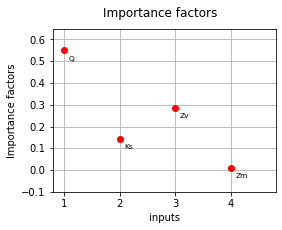

In [7]:
input_names = g_parametric.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    importance_factors, input_names, "Importance factors"
)
graph.setYTitle("Importance factors")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top=0.1 + max(importance_factors))

In [8]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[-57.1067] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[0.00114627,-0.051336,1.14387,-0.200476] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[0.00114627,-0.051336,1.14387,-0.200476] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [9]:
def define_linear_basis(dimension):
    """
    Compute a basis suitable for linear regression.
    
    This basis corresponds to the linear regression model:
    
    Y = beta[0] + beta[1] * X_1 + ... + beta[p] * X_p
   
    where p is the dimension.
    The first item of this basis corresponds to the intercept, i.e. 
    the function is constant and equal to 1.
    The remaining items are identity function, returning the corresponding 
    input variable.
    
    Parameters
    ----------
    dimension : int
        The number of dimensions of the input variable X.
    
    Returns
    -------
    basis : ot.Basis(1 + dimension)
        The functional basis.
    """
    list_of_inputs = ["x%d" % (i) for i in range(dimension)]
    # The intercept
    basis_list = []
    constant_function = ot.SymbolicFunction(list_of_inputs, ["1"])
    basis_list.append(constant_function)
    # The remaining functions
    for i in range(dimension):
        identity_function = ot.SymbolicFunction(list_of_inputs, ["x%d" % (i)])
        basis_list.append(identity_function)
    basis = ot.Basis(basis_list)
    return basis

In [10]:
def compute_least_squares_residual_variance(sampleX, sampleY):
    """
    Compute the variance of the residuals
    
    Parameters
    ----------
    sampleX : ot.Sample(size, input_dimension)
        The input sample.
    sampleY : ot.Sample(size, 1)
        The output sample.
    
    Returns
    -------
    sigma2_hat : float
        The variance of the residuals
    """
    input_dimension = sampleX.getDimension()
    basis = define_linear_basis(input_dimension)
    design_proxy = ot.DesignProxy(sampleX, basis)
    n_parameters = len(basis)
    indices = list(range(n_parameters))
    design_matrix = design_proxy.computeDesign(indices)
    myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
    myLeastSquares.run()
    responseSurface = myLeastSquares.getMetaModel()
    predicted_outputs = responseSurface(sampleX)
    residuals_sample = sampleY - predicted_outputs
    residuals_sample.setDescription(["Residuals"])
    residuals_point = residuals_sample.asPoint()
    sample_size = sampleX.getSize()
    sigma2_hat = residuals_point.normSquare() / (sample_size - n_parameters)
    return sigma2_hat

In [11]:
def compute_least_squares_parameter_distribution(sampleX, sampleY):
    """
    Compute the gaussian distribution of the beta parameter.
    
    This distribution is valid under the hypothesis that the linear 
    least squares problem has a gaussian residual distribution.
    
    Parameters
    ----------
    sampleX : ot.Sample(size, input_dimension)
        The input sample.
    sampleY : ot.Sample(size, 1)
        The output sample.
    
    Returns
    -------
    distribution_betahat : ot.Normal()
        The gaussian distribution of beta_hat.
    """
    input_dimension = sampleX.getDimension()
    basis = define_linear_basis(input_dimension)
    design_proxy = ot.DesignProxy(sampleX, basis)
    n_parameters = len(basis)
    indices = list(range(n_parameters))
    design_matrix = design_proxy.computeDesign(indices)
    myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
    myLeastSquares.run()
    responseSurface = myLeastSquares.getMetaModel()
    predicted_outputs = responseSurface(sampleX)
    residuals_sample = sampleY - predicted_outputs
    residuals_sample.setDescription(["Residuals"])
    residuals_point = residuals_sample.asPoint()
    sample_size = sampleX.getSize()
    sigma2_hat = residuals_point.normSquare() / (sample_size - n_parameters)
    lsq_method = ot.QRMethod(design_proxy, indices)
    observation_point = sampleY.asPoint()
    beta_hat = lsq_method.solve(observation_point)
    inverse_gram = lsq_method.getGramInverse()
    covariance_matrix = ot.CovarianceMatrix(sigma2_hat * inverse_gram)
    distribution_betahat = ot.Normal(beta_hat, covariance_matrix)
    description = [r"$\beta_%d$" % (i) for i in range(n_parameters)]
    distribution_betahat.setDescription(description)
    return distribution_betahat

In [12]:
distribution_betahat = compute_least_squares_parameter_distribution(sampleX, sampleY)
beta_hat = distribution_betahat.getMean()
print("hat(Beta) = ", beta_hat)

hat(Beta) =  [-57.1067,0.00114627,-0.051336,1.14387,-0.200476]


In [13]:
# Compute quantiles
alpha = 0.05
dimension = sampleX.getDimension()
beta_lower_bound = ot.Point(1 + dimension)
beta_upper_bound = ot.Point(1 + dimension)
# We include the distribution of the intercept
for i in range(1 + dimension):
    marginal_beta_distribution = distribution_betahat.getMarginal(i)
    marginal_beta_bounds = marginal_beta_distribution.computeBilateralConfidenceInterval(
        1.0 - alpha
    )
    beta_lower_bound[i] = marginal_beta_bounds.getLowerBound()[0]
    beta_upper_bound[i] = marginal_beta_bounds.getUpperBound()[0]
beta_bounds = ot.Interval(beta_lower_bound, beta_upper_bound)
print(beta_bounds)

[-64.3651, -49.8483]
[0.00106337, 0.00122917]
[-0.0585595, -0.0441125]
[1.02802, 1.25972]
[-0.30185, -0.0991026]


In [14]:
variance_Y = sampleY.computeCovariance()[0, 0]
print("variance_Y = %.3f" % (variance_Y))

variance_Y = 1.247


In the next cell, we compute the importance factors using the linear regression. We are interested only in the coefficients $\hat{\beta}_1, ..., \hat{\beta}_p$ and not in $\hat{\beta}_0$, which is why we have to use a shift of +1 in the indices. 

In [15]:
importance_factors = ot.Point(dimension)
for i in range(dimension):
    marginal_input_distribution = X.getMarginal(i)
    variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
    # We shift beta, because we do not consider the intercept here.
    importance_factors[i] = beta_hat[1 + i] ** 2 * variance_X_i / variance_Y
print(importance_factors)

[0.536471,0.118859,0.349888,0.0107474]


## Confidence bounds from distribution

Given the distribution of $\boldsymbol{\eta}$, the following function computes marginal bounds of level $1 - \alpha$ of the confidence interval.

In [16]:
def compute_bounds_from_eta_distribution(eta_distribution, alpha = 0.05):
    """
    Compute marginal confidence intervals for eta_i given its distribution
    
    Parameters
    ----------
    eta_distribution : ot.Distribution(dimension)
        The joint distribution of the random vector eta.
    
    Returns
    -------
    bounds : ot.Interval(dimension)
        The level 1 - alpha confidence bounds.
    """
    dimension = eta_distribution.getDimension()
    importance_factors_lower_bound = ot.Point(dimension)
    importance_factors_upper_bound = ot.Point(dimension)
    for i in range(dimension):
        eta_i_distribution = eta_distribution.getMarginal(i)
        marginal_bounds = eta_i_distribution.computeBilateralConfidenceInterval(1.0 - alpha)
        importance_factors_lower_bound[i] = marginal_bounds.getLowerBound()[0]
        importance_factors_upper_bound[i] = marginal_bounds.getUpperBound()[0]
    importance_factors_bounds = ot.Interval(
        importance_factors_lower_bound, importance_factors_upper_bound
    )
    return importance_factors_bounds

Once the bounds are computed, the following function plots them.

In [17]:
def plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_bounds
):
    """
    Plot importance factors indices with confidence bounds of level 1 - alpha
    
    Parameters
    ----------
    importance_factors : ot.Point(dimension)
        The importance factors.
    input_names : list(str)
        The names of the input variables.
    alpha : float, in [0, 1]
        The complementary confidence level.
    importance_bounds : ot.Interval(dimension)
        The lower and upper bounds of the importance factors
    
    Returns
    -------
    graph : ot.Graph
        The importance factors indices with lower and upper 1-alpha confidence intervals.
    """
    dim = importance_factors.getDimension()
    lowerBounds = importance_bounds.getLowerBound()
    upperBounds = importance_bounds.getUpperBound()
    palette = ot.Drawable().BuildDefaultPalette(2)
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        importance_factors, input_names, "Importance factors"
    )
    graph.setColors([palette[0], "black"])
    graph.setYTitle("Importance factors")
    title = "Importance factors with bounds at %.2f %%" % ((1 - alpha) * 100)

    graph.setTitle(title)
    # Add confidence bounds
    for i in range(dim):
        curve = ot.Curve([1 + i, 1 + i], [lowerBounds[i], upperBounds[i]])
        curve.setLineWidth(2.0)
        curve.setColor(palette[1])
        graph.add(curve)
    return graph

The goal of the remaining of the script is to compute the distribution of $\boldsymbol{\eta}$. 

## Using distribution arithmetic

We observe that parts of the estimator 
$$
\hat{\eta}_i = \frac{\hat{\beta}_i^2 \mathbb{V}(X_i)}{\hat{\sigma}_Y^2}
$$
for $i = 1, ..., p$ have a known distribution. Indeed, the marginal distribution of $\hat{\beta}_i$ is known, using properties of the linear regression model.

We recognize that if $\hat{\beta}_i \sim \mathcal{N}\left(\mu_{\hat{\beta}_i}, \sigma_{\hat{\beta}_i}^2\right)$, then $\hat{\beta}_i^2$ has a [noncentral chi-squared distribution with one degree of freedom](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution). More precisely, the random variable $\frac{\hat{\beta}_i}{\sigma_{\hat{\beta}_i}}$ is $\mathcal{N}(\mu_{\hat{\beta}_i}, 1)$, which implies that $\left(\frac{\hat{\beta}_i}{\sigma_{\hat{\beta}_i}}\right)^2$ has a noncentral chi-squared distribution with a non centrality parameter $\lambda = \left(\frac{\mu_{\hat{\beta}_i}}{\sigma_{\hat{\beta}_i}}\right)^2$. 

The variable $\hat{\beta}_i^2$ is a chi-squared distribution if $\mu_{\hat{\beta}_i} = 0$ and $\sigma_{\hat{\beta}_i}^2 = 1$. This is unlikely to happen, since we consider a coefficient $\hat{\beta}$ which mean is not necessarily zero and variance is not necessarily equal to 1. 

In the first of this study, we consider that $\hat{\sigma}_Y^2$ is a constant. In the second part, we consider that $\hat{\sigma}_Y^2$ is, indeed, random.

In the next cel, we create a list with the list of distributions of $Z_1, ..., Z_p$. 

In [18]:
Z_distribution_list = []
for i in range(dimension):
    marginal_input_distribution = X.getMarginal(i)
    variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
    marginal_beta_distribution = distribution_betahat.getMarginal(1 + i)
    # Use the arithmetic of distributions
    Z_i_distribution = marginal_beta_distribution ** 2 * variance_X_i
    print(Z_i_distribution)
    Z_distribution_list.append(Z_i_distribution)

RandomMixture(508950 * SquaredNormal(mu = 0.00114627, sigma = 4.22961e-05))
RandomMixture(56.2199 * SquaredNormal(mu = -0.051336, sigma = 0.00368553))
RandomMixture(0.333333 * SquaredNormal(mu = 1.14387, sigma = 0.0591088))
RandomMixture(0.333333 * SquaredNormal(mu = -0.200476, sigma = 0.0517222))


We see that the product of a constant and a `SquaredNormal` is not simplified into a `SquaredNormal`. This is a simplification that could be done by the software. 

### Assuming that the variance of the output is constant

In the first part, we assume that $\hat{\sigma}_Y^2$ is a constant that is, we neglect its variability. The only random variable which remains is $\hat{\beta}_i^2$, for $i = 1, ..., p$.

In [19]:
eta_distribution_list = []
for i in range(dimension):
    Z_i_distribution = Z_distribution_list[i]
    eta_i_distribution = Z_i_distribution / variance_Y
    eta_distribution_list.append(eta_i_distribution)
eta_distribution = ot.ComposedDistribution(eta_distribution_list)

In [20]:
importance_factors_bounds = compute_bounds_from_eta_distribution(eta_distribution)
print(importance_factors_bounds)

[0.461682, 0.616873]
[0.0180567, 0.0180567]
[0.282603, 0.42435]
[0.00262631, 0.0152954]


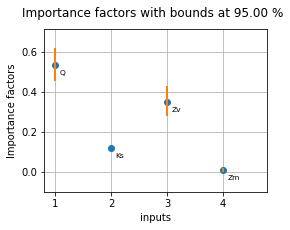

In [21]:
graph = plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_factors_bounds
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top=0.1 + max(importance_factors_bounds.getUpperBound()))

We see that the confidence intervals are correctly centered on the estimate, which is a direct consequence of the method. We notice that the confidence interval for $K_s$ seems to be too small.

### Taking into accout for the randomness of the variance of the output

The distribution of $\hat{\sigma}_Y^2$ is a little more complicated to compute. We known that :
$$
\textrm{V}(Y) = \beta_1^2 \mathbb{V}(X_1) + ... + \beta_p^2 \mathbb{V}(X_p) + \mathbb{V}(\epsilon).
$$
Hence,
$$
\hat{\sigma}_Y^2 = \hat{\beta}_1^2 \mathbb{V}(X_1) + ... + \hat{\beta}_p^2 \mathbb{V}(X_p) + \hat{\sigma}_\epsilon^2.
$$
The distribution of $\hat{\beta}_1^2 \mathbb{V}(X_1) + ... + \hat{\beta}_p^2 \mathbb{V}(X_p)$ is a sum of squared gaussian random variables. The distribution of $\hat{\sigma}_\epsilon^2$ is less easy to compute. 

We may compute the distribution of $\hat{\beta}_i^2$ using the arithmetic of distributions, which leads to a `SquaredNormal` distribution. 

Let:
$$
Z_i = \hat{\beta}_i^2 \mathbb{V}(X_i)
$$
for $i = 1, ..., p$.
Therefore, we are interested in the distribution of :
$$
\hat{\eta}_i = \frac{Z_i}{Z_1 + ... + Z_p + \hat{\sigma}_\epsilon^2}.
$$
We notice that the variables $Z_i$ and $Z_1 + ... + Z_p$ are not independent. 

In the following calculation, we make the approximation :
$$
\hat{\eta}_i \approx \frac{Z_i}{Z_1 + ... + Z_p}
$$
i.e. we assume that the distribution of $\hat{\sigma}_\epsilon^2$ can be neglected. This tends to reduce the variability of the importance factors and may lead to smaller confidence intervals. 

Furthermore, we assume that the random variables $Z_1, ..., Z_p$ are independent. This must increase the variability of the ratio and may lead to larger confidence intervals. 


Finally, we compute the confidence bound, using again the arithmetic of distributions in order to define the ratio $\frac{Z_i}{Z_1 + ... + Z_p}$. We finally create a random vector with independent marginals, with the `ComposedDistribution` class. 

We create the random variable associated with the variable $Z_1 + ... + Z_p$, using the arithmetic of distributions. 

In [22]:
variance_Y_distribution = Z_distribution_list[0]
for i in range(1, dimension):
    variance_Y_distribution += Z_distribution_list[i]
variance_Y_distribution

class=RandomMixture name=RandomMixture distribution collection=[class=SquaredNormal name=SquaredNormal mu=0.00114627 sigma=4.22961e-05,class=SquaredNormal name=SquaredNormal mu=-0.051336 sigma=0.00368553,class=SquaredNormal name=SquaredNormal mu=1.14387 sigma=0.0591088,class=SquaredNormal name=SquaredNormal mu=-0.200476 sigma=0.0517222] weights =class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=4 values=[508950,56.2199,0.333333,0.333333] constant=class=Point name=Unnamed dimension=1 values=[0]

In [23]:
eta_distribution_list = []
for i in range(dimension):
    eta_i_distribution = Z_distribution_list[i] / variance_Y_distribution
    eta_distribution_list.append(eta_i_distribution)
eta_distribution = ot.ComposedDistribution(eta_distribution_list)

In [24]:
importance_factors_bounds = compute_bounds_from_eta_distribution(eta_distribution)
print(importance_factors_bounds)

[0.438491, 0.63023]
[0.0335622, 0.0335622]
[0.270839, 0.429653]
[0.00257199, 0.0284298]


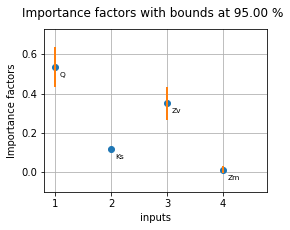

In [25]:
graph = plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_factors_bounds
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top=0.1 + max(importance_factors_bounds.getUpperBound()))

We notice that the bounds are different from than what we may expect. The confidence bound for the variable $K_s$ is very small. This might be the consequence of the fact that we have lost some of the variance considering that $\hat{\sigma}_Y^2$ is not random.

The confidence bounds for some variables do not contain the estimator, especially for $Q$. This might be because we considered the numerator independent from the denominator in the distribution of $\eta_Q$. 


## Using sampling

It is possible to approximate the distribution of $\hat{\boldsymbol{\eta}} = \left( \hat{\eta}_1, ..., \hat{\eta}_p \right)$ by sampling in the distribution of the vector $\hat{\boldsymbol{\beta}}$, neglecting the variability of $\hat{\sigma}^2$. This allows to manage the dependency in the random vector $\hat{ \boldsymbol{\beta}}$ and, furthermore, in the numerator and the denominator of $\hat{\eta}_i$. 

Let $\boldsymbol{h} : \mathbb{R}^p \rightarrow \mathbb{R}^p$ the function defined by:
$$
\hat{\boldsymbol{\eta}} = \boldsymbol{h} \left( \hat{\boldsymbol{\beta}} \right)
$$
that is :
$$
h_i \left( \hat{\beta}_i \right) = \frac{\hat{\beta}_i^2 \mathbb{V}(X_i)}{\sum_{i = 1}^p \hat{\beta}_i^2 \mathbb{V}(X_i) + \hat{\sigma}_i^2}
$$
for any $\hat{\beta}_i \in \mathbb{R}$ and $i = 1, ..., p$. 

In order to implement it, we use a `PythonFunction` which provides an easy way to compute the importance factors. Then we create the `CompositeRandomVector` associated with $\hat{\boldsymbol{\eta}}$, which provides an efficient way to simulate observations from this random vector.

In [26]:
sigma2_hat = compute_least_squares_residual_variance(sampleX, sampleY)
print("sigma2_hat", sigma2_hat)

sigma2_hat 0.09048666564621259


In [27]:
def importance_factor(beta):
    # Take beta[1], ..., beta[p] and return eta[1], ..., eta[p],
    # except that the indices begin at 0.
    # Compute denominator
    variance_Y = 0.0
    for i in range(dimension):
        marginal_input_distribution = X.getMarginal(i)
        variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
        variance_Y += beta[i] ** 2 * variance_X_i
    # Adds the variance of the residuals
    variance_Y += sigma2_hat
    # Compute importance factor
    factor = ot.Point(dimension)
    for i in range(dimension):
        marginal_input_distribution = X.getMarginal(i)
        variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
        numerator = beta[i] ** 2 * variance_X_i
        factor[i] = numerator / variance_Y
    return factor
h_function_eta = ot.PythonFunction(dimension, dimension, importance_factor)

In order to check the function, we get the mean vector $\left(\bar{\hat{\beta}}_1, ..., \bar{\hat{\beta}}_p\right)$ and evaluate the corresponding output $\left( \bar{\hat{\eta}}_1, ..., \bar{\hat{\eta}}_p \right)^T$. Using a Taylor expansion of $\boldsymbol{h}$ in the neighbourhood of $\hat{\boldsymbol{\beta}}$, this is equal to $\mathbb{E}\left( \boldsymbol{\hat{\eta}} \right)$ if the function $\boldsymbol{h}$ is linear. 

In [28]:
distribution_beta = distribution_betahat.getMarginal(range(1, 1 + dimension))
mean_beta = distribution_beta.getMean()
eta_mean = h_function_eta(mean_beta)
print("eta_mean = ", eta_mean)

eta_mean =  [0.492828,0.109189,0.321424,0.00987304]


In [29]:
sum(eta_mean)

0.9333145749305876

In [30]:
beta_random_vector = ot.RandomVector(distribution_beta)
eta_random_vector = ot.CompositeRandomVector(h_function_eta, beta_random_vector)

sample_size = 100
eta_sample = eta_random_vector.getSample(sample_size)
eta_sample[:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=4 description=[y0,y1,y2,y3] data=[[0.488948,0.105797,0.317975,0.0212124],[0.49517,0.100991,0.321272,0.019938],[0.48497,0.109334,0.32984,0.00964379],[0.5061,0.111267,0.299793,0.0145318],[0.490824,0.125857,0.315656,0.00528524]]

In [31]:
eta_distribution = ot.KernelSmoothing().build(eta_sample)

In [32]:
importance_factors_bounds = compute_bounds_from_eta_distribution(eta_distribution)
print(importance_factors_bounds)

[0.445991, 0.544065]
[0.0725541, 0.143889]
[0.263286, 0.369778]
[-0.000421587, 0.0240295]


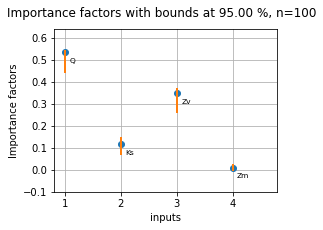

In [33]:
graph = plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_factors_bounds
)
graph.setTitle("Importance factors with bounds at %.2f %%, n=%d" % ((1 - alpha) * 100, sampleSize))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top=0.1 + max(importance_factors_bounds.getUpperBound()))
pl.savefig("Exercice_SRC_with_LLSQ_and_KDE.pdf", bbox_inches="tight")

We see that the confidence bounds are consistent with the estimators, although there is a slight discrepancy for the variable $Q$. The confidence interval for $K_s$ is now nonzero, which is more satisfactory than with the previous methods.

## Conclusion

One of the ways to explore this topic further would be to use the delta-method to estimate the asymptotic distribution of $\eta_i$. This might be interesting because we generally estimate these coefficients using relatively large sample sizes, typically with $n > 100$. Hence, the asymptotic assumption might be valid in this case.